In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import multiprocessing as mp
import time
import glob
import re
import random
from sklearn.model_selection import train_test_split
import torch

sys.path.insert(0, '/Data/user/panhailin/git_lab/npspy')
import npspy as nps

# 全局配置

In [3]:
torch.set_num_threads(10)

all_peps = [
    'hp1_1', 'hp1_2', 'hp1_3', 'hp1_4', 'hp1_5', 'hp1_6', 'hp1_7', 'hp1_8', 'hp1_9',
    'hp2_1', 'hp2_2', 'hp2_3', 'hp2_4', 'hp2_5', 'hp2_6',
]

y_code_dict = nps.ml.set_y_codes_for_classes(np.array(all_peps)[:,None])
y_code_dict
y_to_label_dict = {v:k for k,v in y_code_dict.items()}
y_code_dict, y_to_label_dict

({np.str_('hp1_1'): 0,
  np.str_('hp1_2'): 1,
  np.str_('hp1_3'): 2,
  np.str_('hp1_4'): 3,
  np.str_('hp1_5'): 4,
  np.str_('hp1_6'): 5,
  np.str_('hp1_7'): 6,
  np.str_('hp1_8'): 7,
  np.str_('hp1_9'): 8,
  np.str_('hp2_1'): 9,
  np.str_('hp2_2'): 10,
  np.str_('hp2_3'): 11,
  np.str_('hp2_4'): 12,
  np.str_('hp2_5'): 13,
  np.str_('hp2_6'): 14},
 {0: np.str_('hp1_1'),
  1: np.str_('hp1_2'),
  2: np.str_('hp1_3'),
  3: np.str_('hp1_4'),
  4: np.str_('hp1_5'),
  5: np.str_('hp1_6'),
  6: np.str_('hp1_7'),
  7: np.str_('hp1_8'),
  8: np.str_('hp1_9'),
  9: np.str_('hp2_1'),
  10: np.str_('hp2_2'),
  11: np.str_('hp2_3'),
  12: np.str_('hp2_4'),
  13: np.str_('hp2_5'),
  14: np.str_('hp2_6')})

In [4]:
train_objs = [f"../../../00.data/{pep}_valid80.pkl" for pep in all_peps]
test_objs = [f"../../../00.data/{pep}_valid20.pkl" for pep in all_peps]
labels = all_peps

In [5]:
def stratified_sample(df, column_name, sample_size=15000, random_state=42):
    """
    对DataFrame按指定列类别分层随机抽样
    
    参数:
        df: 输入DataFrame
        column_name: 分层依据的列名
        sample_size: 每类抽取样本数(默认15000)
        random_state: 随机种子
    
    返回:
        抽样后的新DataFrame
    """
    re_df = df.groupby(column_name, group_keys=True).apply(
        lambda x: x.sample(min(len(x), sample_size), 
                          random_state=random_state),
        include_groups=False,
    )
    re_df[re_df.index.names[0]] =  [i[0] for i in re_df.index]
    re_df.index = [i[1] for i in re_df.index]
    return re_df

# 读取pkl文件，生成readid，X，y组成的df

In [ ]:
seed = 1
train_df = nps.ml.get_X_y_from_objs(objs=train_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
train_df = stratified_sample(train_df, 'y', sample_size=25000, random_state=seed)
train_df, valid_df = train_test_split(train_df, test_size=1/8, random_state=seed, stratify=train_df['y'])
test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
test_df = stratified_sample(test_df, 'y', sample_size=6000, random_state=seed)

# 通过data_df构建dataloader

In [21]:
batch_size = 128
train_dl = nps.ml.construct_dataloader_from_data_df(train_df, batch_size=batch_size, augment=False)
valid_dl = nps.ml.construct_dataloader_from_data_df(valid_df, batch_size=batch_size)
test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)

# 初步训练

In [23]:
nps.ml.seed_everything(seed)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')
clf.fit(train_dl, valid_dl, early_stopping_patience=30, name='valid_data')

Model CNN1DL1000 has total parameter number: 6.21 M
Epoch   0 / 200 train_loss: 1.2432 train_acc: 0.7271 val_loss: 1.0308 val_acc: 0.8137 lr: 0.005
Epoch   1 / 200 train_loss: 0.9540 train_acc: 0.8509 val_loss: 1.2691 val_acc: 0.7122 lr: 0.005
Epoch   2 / 200 train_loss: 0.8799 train_acc: 0.8801 val_loss: 1.1615 val_acc: 0.7591 lr: 0.005
Epoch   3 / 200 train_loss: 0.8370 train_acc: 0.8964 val_loss: 1.2595 val_acc: 0.7271 lr: 0.005
Epoch   4 / 200 train_loss: 0.8053 train_acc: 0.9082 val_loss: 0.9356 val_acc: 0.8480 lr: 0.005
Epoch   5 / 200 train_loss: 0.7833 train_acc: 0.9168 val_loss: 0.8729 val_acc: 0.8784 lr: 0.005
Epoch   6 / 200 train_loss: 0.7631 train_acc: 0.9244 val_loss: 1.3552 val_acc: 0.6829 lr: 0.005
Epoch   7 / 200 train_loss: 0.7472 train_acc: 0.9309 val_loss: 0.8967 val_acc: 0.8620 lr: 0.005
Epoch   8 / 200 train_loss: 0.7335 train_acc: 0.9362 val_loss: 0.9961 val_acc: 0.8242 lr: 0.005
Epoch   9 / 200 train_loss: 0.7210 train_acc: 0.9407 val_loss: 0.8413 val_acc: 0.887

In [24]:
pred_df = clf.predict(test_dl, name='valid_data', y_to_label_dict=y_to_label_dict)
test_all_reads_s = pred_df['true'].value_counts()
cm_df = nps.ml.get_cm(pred_df, label_order=all_peps)
cm_df.to_csv("../../../04.tables/classification/hp12/hp_valid.csv")
print(cm_df)
print(np.sum(np.diag(cm_df))/len(pred_df))

 test_acc: 0.9342
pred   hp1_1  hp1_2  hp1_3  hp1_4  hp1_5  hp1_6  hp1_7  hp1_8  hp1_9  hp2_1  \
true                                                                          
hp1_1   5471     52     12      8     40      2      2      4      6      4   
hp1_2     91   5588      9     17     11      9      4      6     12     14   
hp1_3     28     14   5655     14     12     36      4     45    100     15   
hp1_4     17     29      4   5500      6     90      4     20     14    106   
hp1_5     50     12     10     16   5756     10      6      3      6      0   
hp1_6     13      5     31     95     20   5485      5    110    108     46   
hp1_7      5      8      8     12      6      6   5755      1     13     12   
hp1_8     14      1     32     35      3    133      2   5585    145     12   
hp1_9     17     18     92     25     11     95      5     91   5537     15   
hp2_1      7     17     18     84      1     33      3     17     18   5697   
hp2_2     48     16      4     31 

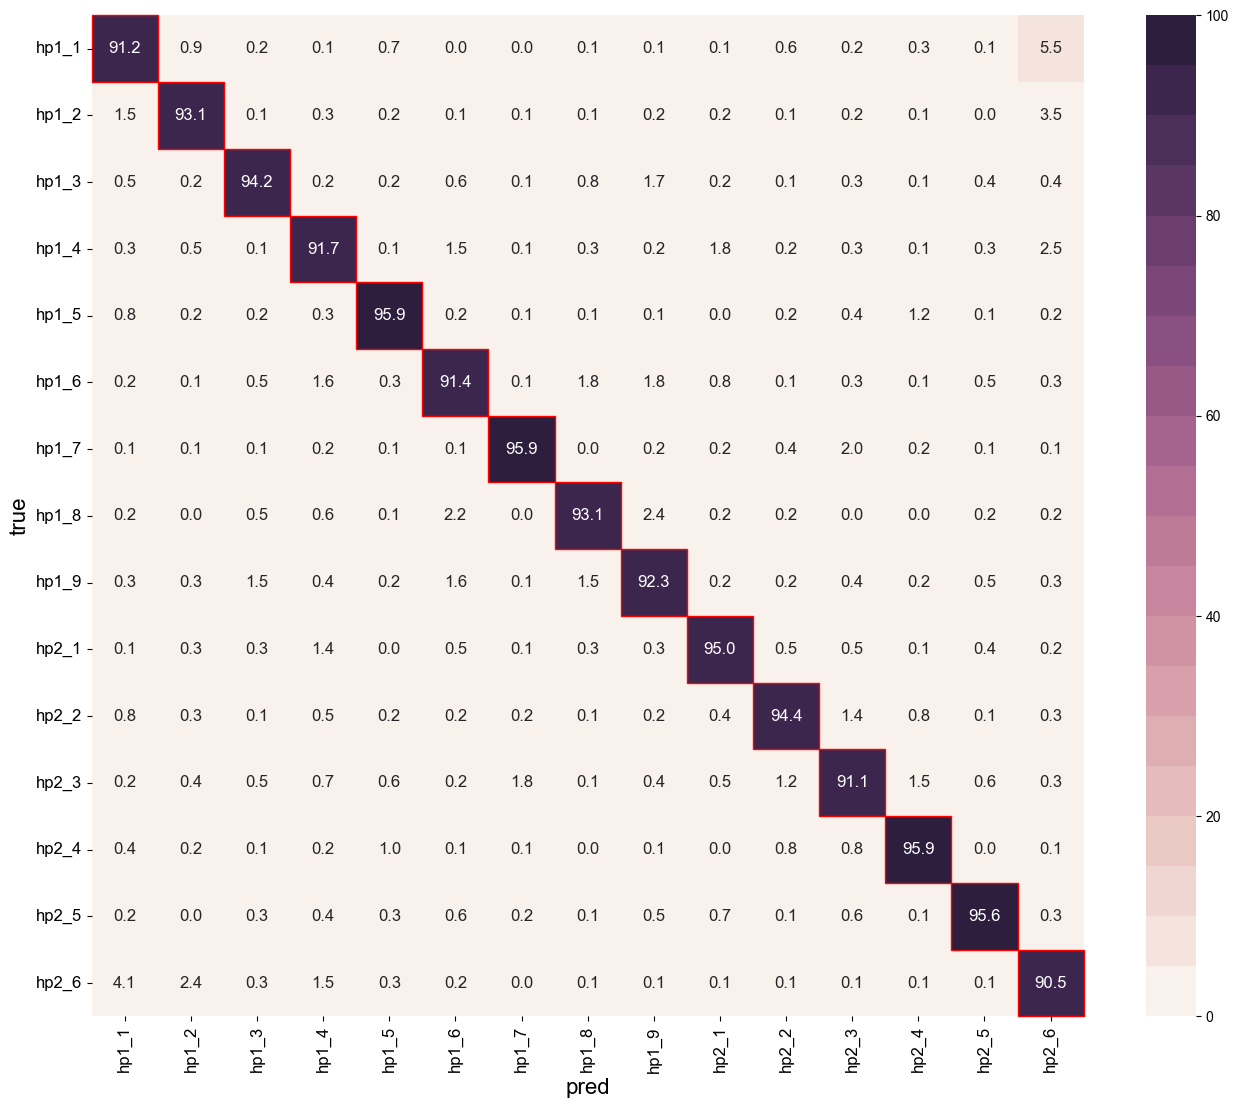

In [25]:
cm_df = pd.read_csv("../../../04.tables/classification/hp12/hp_valid.csv", index_col=0)
cm_df.columns.name= 'pred'
plt.rcParams['axes.labelsize'] = 16
nps.ml.plot_cm(cm_df, figsize=(16,13), nor_to_percent_for_each_pred=True, annot_size=12.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("../../../05.figures/classification/hp12/hp12_valid_cm.pdf")

# 看预测概率的分布

In [29]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')

Model CNN1DL1000 has total parameter number: 6.21 M


In [30]:
pred_proba_df = clf.predict_proba(test_dl, name='valid_data',)

 test_acc: 0.9342


<Axes: ylabel='Density'>

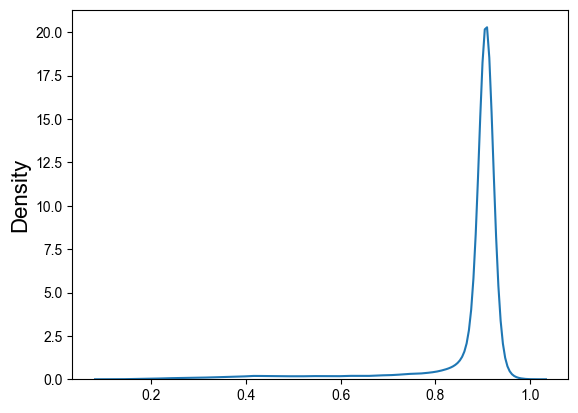

In [31]:
sns.kdeplot(pred_proba_df.iloc[:,0:-1].max(axis=1))